## MSDS458 Research Assignment 3 - Part 3 1DCNN, data cleaning

### Import Packages

In [ ]:
from packaging import version
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import string

import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

import nltk
from nltk.corpus import stopwords

### Verify TensorFlow version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.19.0


### Plotting Model Performance Metrics

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Mount Google Drive to Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/A3')

### Load Data

In [ ]:
dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:90%]','train[90%:]', 'test'],batch_size = 64
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset

### Preparing Integer Sequence Datasets

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [ ]:
#Load text vectorization layers
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_5000.keras')
vectorize_layer_5000 = loaded_vectorize_layer_model.layers[0]

In [ ]:
int_train_ds = train_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)

In [ ]:
max_tokens=len(vectorize_layer_5000.get_vocabulary())

### Experiment 8: 1D CNN

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256)(inputs)

x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(embedded)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 256)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 32)       │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,084 (5.01 MB)

 Trainable params: 1,314,084 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1DCNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("1DCNN.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.7924 - loss: 0.5467 - val_accuracy: 0.8873 - val_loss: 0.4000
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 76s 22ms/step - accuracy: 0.8968 - loss: 0.2945 - val_accuracy: 0.8894 - val_loss: 0.3787
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9092 - loss: 0.2581 - val_accuracy: 0.8908 - val_loss: 0.3412
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - accuracy: 0.9174 - loss: 0.2338 - val_accuracy: 0.8889 - val_loss: 0.3307
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9226 - loss: 0.2152 - val_accuracy: 0.8882 - val_loss: 0.3321
Epoch 6/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.9293 - loss: 0.1960 - val_accuracy: 0.8901 - val_loss: 0.3263
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8950 - loss: 0.3159
Test acc: 0.896
CPU times: user 5min 48s, sys: 11.9 s, total: 6min
Wall time: 4min 43s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
1,0.900,0.288,0.889,0.379
2,0.910,0.255,0.891,0.341
3,0.918,0.231,0.889,0.331
4,0.924,0.212,0.888,0.332
5,0.929,0.196,0.890,0.326


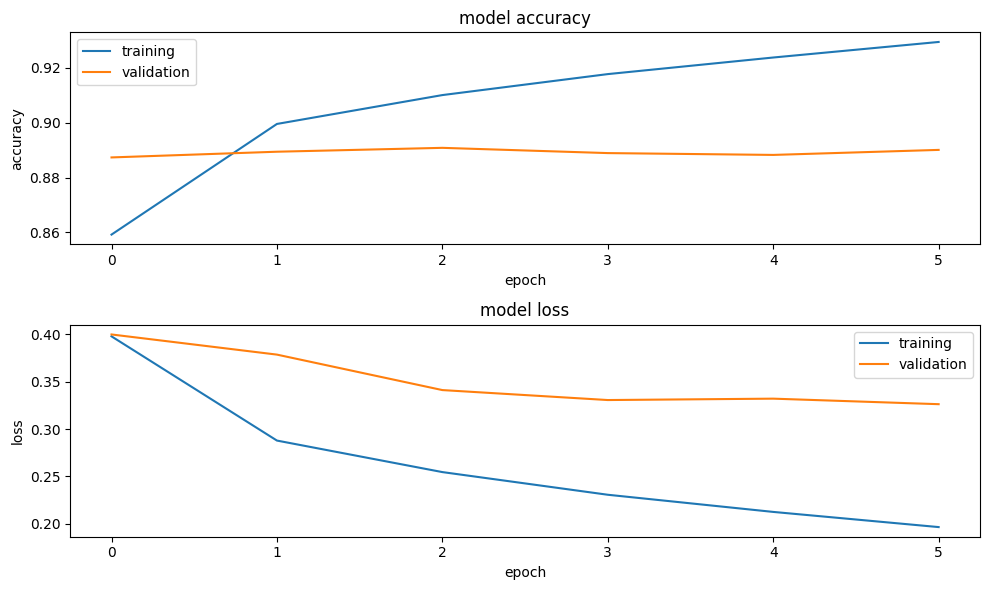

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1900
           1       0.95      0.96      0.96      1900
           2       0.87      0.85      0.86      1900
           3       0.86      0.87      0.86      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Accuracy Score: 0.8957894736842106
Root Mean Square Error: 0.5735393346764044


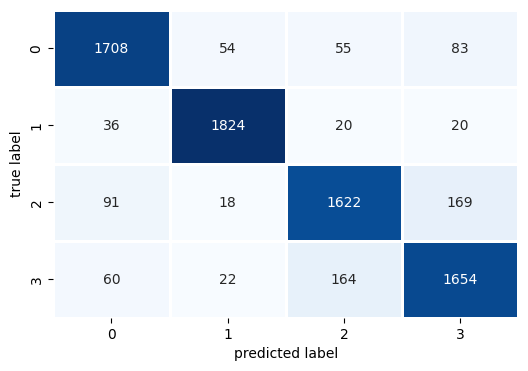

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
class_names = info.features['label'].names
print(class_names)

['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
test_text = np.concatenate([x for x, y in test_ds], axis=0)

# Identify indices of misclassified examples for Business (label 2) and Sci/Tech (label 3)
misclassified_indices = [i for i in range(len(y_test)) if (y_test[i] == 2 or y_test[i] == 3) and y_test[i] != pred_classes[i]]

print("Examples of misclassified Business and Sci/Tech articles:")
for i in range(min(20, len(misclassified_indices))):
    index = misclassified_indices[i]
    true_class = y_test[index]
    predicted_class = pred_classes[index]
    print(f"--- Example {i+1} ---")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Article: {test_text[index]}")
    print("-" * 20)

Examples of misclassified Business and Sci/Tech articles:
--- Example 1 ---
True Class: 3
Predicted Class: 2
Article: b'Geneva - Worldwide sales of industrial robots surged to record levels in the first half of 2004 after equipment prices fell while labour costs grew, the United Nations Economic Commission for Europe said in a report to be released today.'
--------------------
--- Example 2 ---
True Class: 3
Predicted Class: 2
Article: b'Individually theyve been unstoppable in their respective industries. Theyre both legends that have survived the dot com burst and came out winners.'
--------------------
--- Example 3 ---
True Class: 3
Predicted Class: 2
Article: b'Ivan, Frances and Charley delivered three staggering blows to the Gulf Coast and Florida, as well as Caribbean island nations, all in just five weeks.'
--------------------
--- Example 4 ---
True Class: 3
Predicted Class: 2
Article: b"Scott McGregor, former head of Royal Philips Electronics' semiconductor division, will repl

### Experiment 9: cross validation to identify likely mislabeled data in the entire dataset

In [ ]:
dataset, info = tfds.load(
    'ag_news_subset',
    with_info=True,
    split='train+test',
    as_supervised=True
)

all_data_int_ds = dataset.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
max_sequence_length = 0
for x, y in all_data_int_ds:
  if tf.shape(x)[0] > max_sequence_length:
    max_sequence_length = tf.shape(x)[0]

X_list = []
y_list = []

for x, y in all_data_int_ds:
    padded_x = tf.pad(x, [[0, max_sequence_length - tf.shape(x)[0]]], constant_values=0)
    X_list.append(padded_x.numpy())
    y_list.append(y.numpy())


X = np.array(X_list)
y = np.array(y_list)

num_samples = len(X)
print(f"Total samples for cross-validation: {num_samples}")

Total samples for cross-validation: 127600


In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256)(inputs)

Z = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(embedded)
Z = layers.Dropout(0.5)(Z)
Z = layers.MaxPooling1D(pool_size=2)(Z)
Z = layers.GlobalMaxPooling1D()(Z)
Z = layers.Dense(256, activation='relu')(Z)
outputs = layers.Dense(4, activation="softmax")(Z)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

In [ ]:
N_SPLITS = 10
LOSS_THRESHOLD = 1
EPOCHS = 2

In [ ]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

sample_losses = defaultdict(list)

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Run cross-validation three times
for run in range(3):
    print(f"Starting cross-validation run {run + 1}")
    for fold, (train_index, filter_index) in enumerate(kf.split(X, y)):

        X_train, X_filter = X[train_index], X[filter_index]
        y_train, y_filter = y[train_index], y[filter_index]

        # Convert back to TensorFlow datasets for model training and evaluation
        train_ds_fold = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
        filter_ds_fold = tf.data.Dataset.from_tensor_slices((X_filter, y_filter)).batch(64)

        model.fit(train_ds_fold, epochs=EPOCHS, verbose=0)

        y_pred_probs = model.predict(filter_ds_fold, verbose=0)

        fold_losses = tf.keras.losses.sparse_categorical_crossentropy(y_filter, y_pred_probs).numpy()

        for i, original_index in enumerate(filter_index):
            sample_losses[original_index].append(fold_losses[i])

Starting cross-validation run 1
Starting cross-validation run 2
Starting cross-validation run 3


In [ ]:
import pickle
losses_filename = "sample_losses.pkl"
with open(losses_filename, 'wb') as f:
    pickle.dump(sample_losses, f)

In [ ]:
import pickle
losses_filename = "sample_losses.pkl"
with open(losses_filename, 'rb') as f:
    loaded_sample_losses = pickle.load(f)

In [ ]:
sample_losses = loaded_sample_losses

In [ ]:
max_losses = {}
for idx, losses in sample_losses.items():
    max_losses[idx] = np.max(losses)

sorted_losses = sorted(max_losses.items(), key=lambda item: item[1], reverse=True)

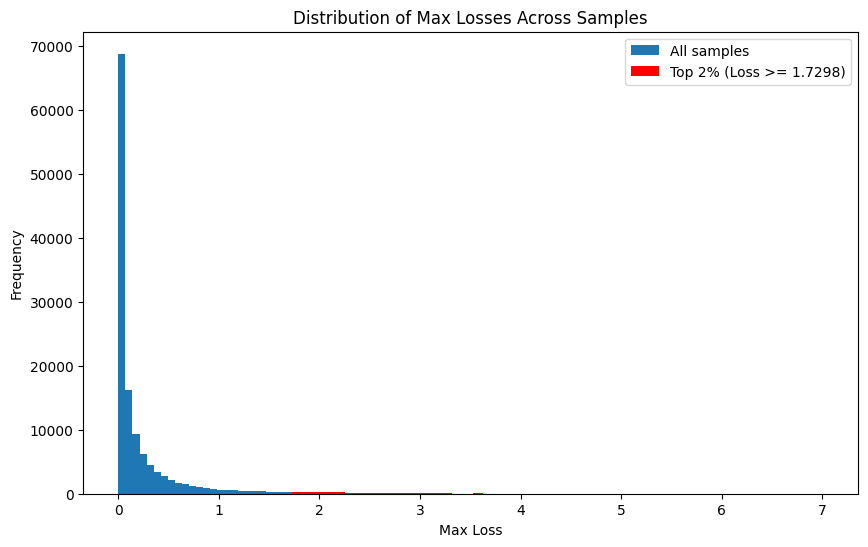

In [ ]:
losses_values = [loss for idx, loss in sorted_losses]

plt.figure(figsize=(10, 6))

plt.hist(losses_values, bins=100, label='All samples')

# Calculate the threshold for the top 2% of losses
top_2_percent_threshold = np.percentile(losses_values, 98)

plt.hist([loss for loss in losses_values if loss >= top_2_percent_threshold], bins=50, color='red', label=f'Top 2% (Loss >= {top_2_percent_threshold:.4f})')

#plt.vlines(x=1, ymin=0, ymax=plt.gca().get_ylim()[1], linestyles="dotted", colors="green", label=f'Loss Threshold ({LOSS_THRESHOLD})')

plt.title('Distribution of Max Losses Across Samples')
plt.xlabel('Max Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
mislabeled_indices = [
    idx for idx, loss in sorted_losses
    if loss > top_2_percent_threshold
]

In [ ]:
mislabeled_indices_filename = "mislabeled_indices.pkl"
with open(mislabeled_indices_filename, 'wb') as f:
    pickle.dump(mislabeled_indices, f)

In [ ]:
print("\n" + "="*50)
print("CROSS-VALIDATION FILTERING SUMMARY")
print("="*50)
print(f"Total samples: {127600}")
print(f"Identified Mislabeled Samples (Loss > {top_2_percent_threshold}): {len(mislabeled_indices)}")

mislabeled_indices_ds = tf.data.Dataset.from_tensor_slices(mislabeled_indices)

mean_losses_tensor = tf.scatter_nd(
    indices=tf.constant(list(mean_losses.keys()), dtype=tf.int64)[:, tf.newaxis],
    updates=tf.constant(list(mean_losses.values()), dtype=tf.float32),
    shape=[127600]
)

def get_mislabeled_element_with_details(index, original_element):
    text, true_label = original_element
    loss = tf.gather(mean_losses_tensor, tf.cast(index, tf.int64))
    return text, true_label, loss


# Map the indices to the original dataset elements and add loss and predicted label
mislabeled_data_ds = mislabeled_indices_ds.map(
    lambda idx: (idx, dataset.skip(tf.cast(idx, tf.int64)).take(1).get_single_element()),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda idx, original_element: get_mislabeled_element_with_details(idx, original_element),
    num_parallel_calls=tf.data.AUTOTUNE
)


print("\nExamples of Original Text for Top 20 Mislabeled Samples:")
for i, (text, true_label, loss) in enumerate(mislabeled_data_ds.take(20)):
    print(f"--- Sample (Loss: {loss.numpy():.4f}, True Label: {true_label.numpy()}")
    print(f"Article: {text.numpy().decode('utf-8')}")
    print("-" * 20)


CROSS-VALIDATION FILTERING SUMMARY
Total samples: 127600
Identified Mislabeled Samples (Loss > 1.7297894954681396): 2552

Examples of Original Text for Top 20 Mislabeled Samples:
--- Sample (Loss: 7.0066, True Label: 3
Article: The Philippines Saturday expressed quot;deepest sympathy quot; to the families of the dead in the Russian school siege on Friday, in which 322 people were killed when Russian troops stormed 
--------------------
--- Sample (Loss: 6.8475, True Label: 3
Article: Asian stocks had the biggest gain in seven months on optimism the US economy is growing after the Federal Reserve raised interest rates and a government report showed an unexpected increase in retail sales last month.
--------------------
--- Sample (Loss: 6.6154, True Label: 3
Article: AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend poring over questionnaires prepared to question potential jurors individually.
--------------------
--- Sa

In [ ]:
print("\nExamples of Original Text for Last 20 Mislabeled Samples:")
for i, (text, true_label, loss) in enumerate(mislabeled_data_ds.skip(tf.data.experimental.cardinality(mislabeled_data_ds) - 20).take(20)):
    print(f"--- Sample (Loss: {loss.numpy():.4f}, True Label: {true_label.numpy()}")
    print(f"Article: {text.numpy().decode('utf-8')}")
    print("-" * 20)


Examples of Original Text for Last 20 Mislabeled Samples:
--- Sample (Loss: 1.7368, True Label: 0
Article: Huge crowds greet football legend George Weah on his return home to Liberia to launch a presidential bid.
--------------------
--- Sample (Loss: 1.7359, True Label: 3
Article: Reuters - The U.S. Bureau of Land Management's\Utah state office said on Wednesday it is deferring an auction\this week of oil and natural gas leases near the Hovenweep
--------------------
--- Sample (Loss: 1.7352, True Label: 2
Article: Seattle, September 29: Microsoft Corp and Amazon.com Inc jointly filed lawsuits against e-mail spammers and scams to get unsuspecting users to divulge credit card and account information, the two companies said on Tuesday.
--------------------
--- Sample (Loss: 1.7348, True Label: 3
Article: The legendary chipmaker has cancelled a succession of high-profile projects, replaced managers and fallen behind a key competitor.
--------------------
--- Sample (Loss: 1.7346, True L

In [ ]:
mislabeled_indices_tf = tf.constant(mislabeled_indices, dtype=tf.int64)

cleaned_data_int_ds = dataset.enumerate().filter(
    lambda i, x: tf.reduce_any(tf.equal(tf.cast(i, tf.int64), mislabeled_indices_tf)) == False
).map(lambda i, x: x)

print(f"Original number of samples: {tf.data.experimental.cardinality(dataset).numpy()}")
print(f"Number of mislabeled samples removed: {len(mislabeled_indices)}")

Original number of samples: 127600
Number of mislabeled samples removed: 2552


In [ ]:
cleaned_data_dir = 'cleaned_ag_news_subset_2'
tf.data.Dataset.save(cleaned_data_int_ds, cleaned_data_dir)

In [ ]:
loaded_cleaned_data_ds = tf.data.Dataset.load('cleaned_ag_news_subset_2')

dataset_size = tf.data.experimental.cardinality(loaded_cleaned_data_ds).numpy()
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

cleaned_train_ds = loaded_cleaned_data_ds.take(train_size)
cleaned_val_ds = loaded_cleaned_data_ds.skip(train_size).take(val_size)
cleaned_test_ds = loaded_cleaned_data_ds.skip(train_size + val_size).take(test_size)

print(f"Cleaned dataset size (after saving and loading): {dataset_size}")
print(f"Cleaned training dataset size: {tf.data.experimental.cardinality(cleaned_train_ds).numpy()}")
print(f"Cleaned validation dataset size: {tf.data.experimental.cardinality(cleaned_val_ds).numpy()}")
print(f"Cleaned test dataset size: {tf.data.experimental.cardinality(cleaned_test_ds).numpy()}")

Cleaned dataset size (after saving and loading): 125048
Cleaned training dataset size: 100038
Cleaned validation dataset size: 12504
Cleaned test dataset size: 12506


In [ ]:
def pad_sequences(text, label, max_len=96):
    padded_text = tf.pad(text, [[0, max_len - tf.shape(text)[0]]], constant_values=0)
    padded_text.set_shape([max_len])
    return padded_text, label

int_train_ds = cleaned_train_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: pad_sequences(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
).batch(64).prefetch(tf.data.AUTOTUNE)

int_val_ds = cleaned_val_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: pad_sequences(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
).batch(64).prefetch(tf.data.AUTOTUNE)

int_test_ds = cleaned_test_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: pad_sequences(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
).batch(64).prefetch(tf.data.AUTOTUNE)

Retest 1D CNN model

In [ ]:
def build_1d_cnn_model(max_tokens):
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens
                                ,output_dim=256)(inputs)

    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(embedded)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="nadam",
                  loss="SparseCategoricalCrossentropy",
                  metrics=["accuracy"])
    return model

model = build_1d_cnn_model(max_tokens)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 256)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, None, 32)       │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,084 (5.01 MB)

 Trainable params: 1,314,084 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1DCNN_cleaned_data.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("1DCNN_cleaned_data.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 145s 89ms/step - accuracy: 0.8066 - loss: 0.5103 - val_accuracy: 0.9067 - val_loss: 0.3161
Epoch 2/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 138s 86ms/step - accuracy: 0.9154 - loss: 0.2392 - val_accuracy: 0.9116 - val_loss: 0.2848
Epoch 3/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 146s 89ms/step - accuracy: 0.9272 - loss: 0.2005 - val_accuracy: 0.9099 - val_loss: 0.2726
Epoch 4/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.9354 - loss: 0.1765 - val_accuracy: 0.9101 - val_loss: 0.2638
Epoch 5/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.9417 - loss: 0.1578 - val_accuracy: 0.9083 - val_loss: 0.2591
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9079 - loss: 0.2652
Test acc: 0.909
CPU times: user 16min 17s, sys: 36.6 s, total: 16min 53s
Wall time: 11min 39s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.874,0.352,0.907,0.316
1,0.917,0.233,0.912,0.285
2,0.928,0.198,0.910,0.273
3,0.936,0.175,0.910,0.264
4,0.943,0.155,0.908,0.259


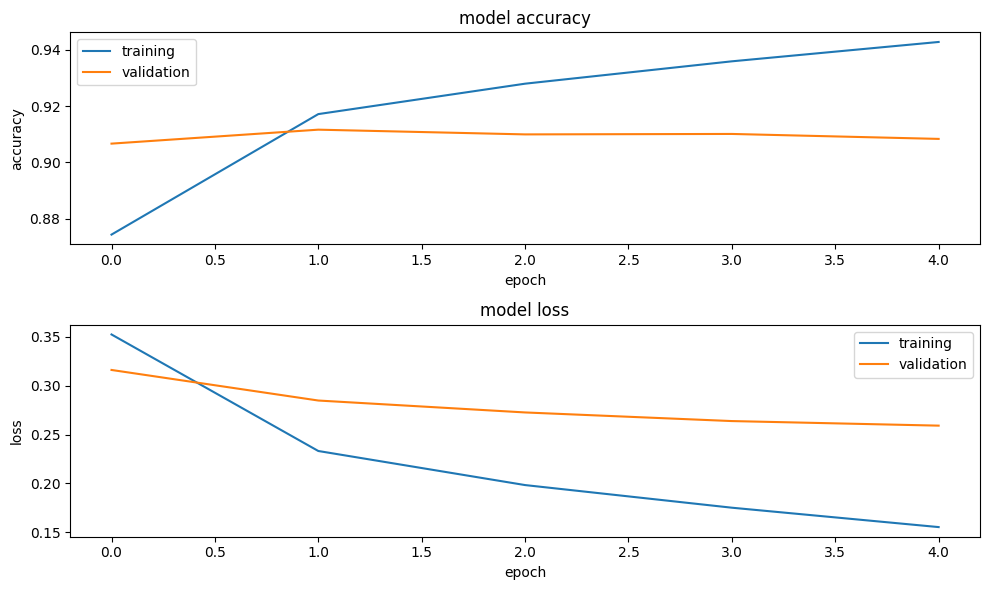

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3210
           1       0.94      0.97      0.96      3180
           2       0.87      0.90      0.89      3000
           3       0.88      0.87      0.88      3116

    accuracy                           0.91     12506
   macro avg       0.91      0.91      0.91     12506
weighted avg       0.91      0.91      0.91     12506

Accuracy Score: 0.9085239085239085
Root Mean Square Error: 0.5420138246268986


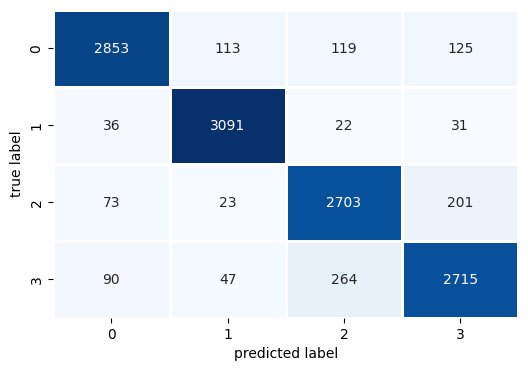

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
test_text_list = [x.numpy() for x, y in cleaned_test_ds]
test_text = np.array(test_text_list)

# Identify indices of misclassified examples for Business (label 2) and Sci/Tech (label 3)
misclassified_indices = [i for i in range(len(y_test)) if (y_test[i] == 2 or y_test[i] == 3) and y_test[i] != pred_classes[i]]

print("Examples of misclassified Business and Sci/Tech articles:")
for i in range(min(20, len(misclassified_indices))):
    index = misclassified_indices[i]
    true_class = y_test[index]
    predicted_class = pred_classes[index]
    print(f"--- Example {i+1} ---")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Article: {test_text[index].decode('utf-8')}")
    print("-" * 20)

Examples of misclassified Business and Sci/Tech articles:
--- Example 1 ---
True Class: 3
Predicted Class: 2
Article: LOS ANGELES, Oct. 28 -- Shares of DreamWorks Animation Inc. soared nearly 38 percent on the first day of trading Thursday as investors anticipated Shrek-sized profits from the computer animation film studio.
--------------------
--- Example 2 ---
True Class: 2
Predicted Class: 3
Article: DECEMBER 13, 2004 (IDG NEWS SERVICE) - 3Com Corp. became the latest company to scoop up technology for preventing attacks on computer networks, announcing today that it is acquiring Austin-based TippingPoint Technologies Inc.
--------------------
--- Example 3 ---
True Class: 2
Predicted Class: 0
Article: Pharmaceutical stocks were mixed in afternoon trading, performing slightly better than the Dow Jones Industrial Average but seeing sharp declines in smaller stocks on clinical trial snags.
--------------------
--- Example 4 ---
True Class: 3
Predicted Class: 2
Article: DOA developer he

### Experiment 10: dilated 1D CNN

In [ ]:
inputs = tf.keras.Input(shape=[None, ],dtype='int64')
embedded = layers.Embedding(input_dim=max_tokens
                                    ,output_dim=256)(inputs)

# Parallel Conv1D layers with different dilation rates
conv_outputs = []
for rate in (1, 2, 4, 8):
    conv_outputs.append(layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate)(embedded))

x = layers.concatenate(conv_outputs)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 256) │  1,280,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 128) │          0 │ conv1d_40[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_41[0][0],  │
│                     │                   │            │ conv1d_42[0][0],  │
│                     │                   │            │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ concatenate_4[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        260 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,354,180 (5.17 MB)

 Trainable params: 1,354,180 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1DCNN_dilation_max_pooling.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("1DCNN_dilation_max_pooling.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.7901 - loss: 0.5568 - val_accuracy: 0.9105 - val_loss: 0.2543
Epoch 2/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9124 - loss: 0.2557 - val_accuracy: 0.9114 - val_loss: 0.2493
Epoch 3/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9254 - loss: 0.2094 - val_accuracy: 0.9140 - val_loss: 0.2400
Epoch 4/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9351 - loss: 0.1843 - val_accuracy: 0.9151 - val_loss: 0.2447
Epoch 5/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9413 - loss: 0.1595 - val_accuracy: 0.9148 - val_loss: 0.2596
Epoch 6/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9480 - loss: 0.1437 - val_accuracy: 0.9122 - val_loss: 0.2652
Epoch 7/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9543 - loss: 0.1282 - val_accuracy: 0.9132 - val_loss: 0.2796
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9119 - loss: 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
2,0.927,0.206,0.914,0.240
3,0.936,0.180,0.915,0.245
4,0.943,0.157,0.915,0.260
5,0.948,0.142,0.912,0.265
6,0.954,0.127,0.913,0.280


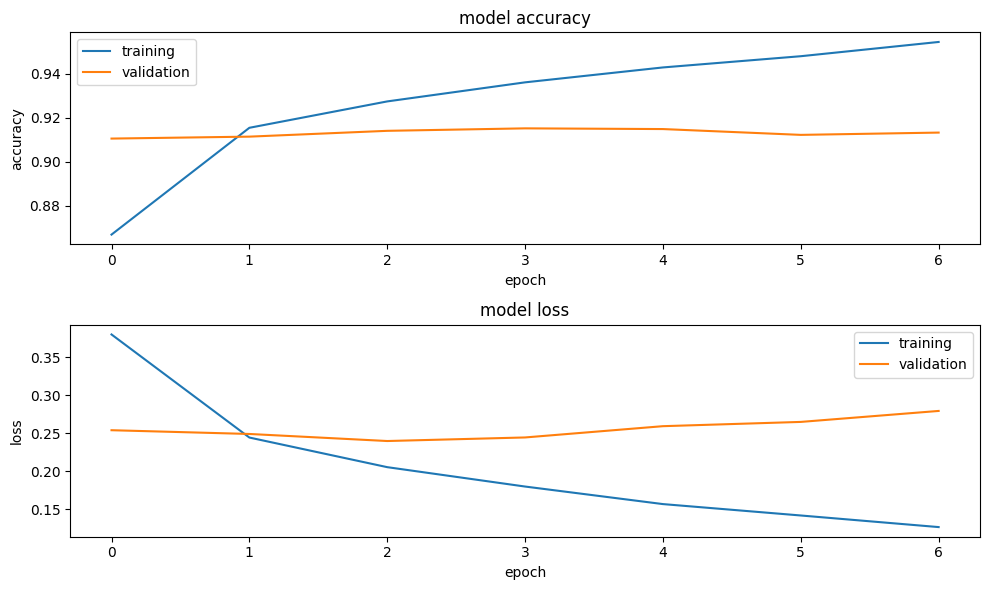

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3210
           1       0.95      0.97      0.96      3180
           2       0.88      0.90      0.89      3000
           3       0.89      0.89      0.89      3116

    accuracy                           0.91     12506
   macro avg       0.91      0.91      0.91     12506
weighted avg       0.91      0.91      0.91     12506

Accuracy Score: 0.9134815288661442
Root Mean Square Error: 0.5345117983973221


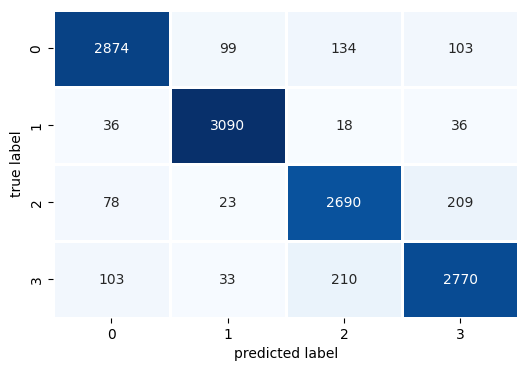

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
test_text_list = [x.numpy() for x, y in cleaned_test_ds]
test_text = np.array(test_text_list)

misclassified_indices = [i for i in range(len(y_test)) if (y_test[i] == 2 or y_test[i] == 3) and y_test[i] != pred_classes[i]]

print("Examples of misclassified Business and Sci/Tech articles:")
for i in range(min(20, len(misclassified_indices))):
    index = misclassified_indices[i]
    true_class = y_test[index]
    predicted_class = pred_classes[index]
    print(f"--- Example {i+1} ---")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Article: {test_text[index].decode('utf-8')}")
    print("-" * 20)

Examples of misclassified Business and Sci/Tech articles:
--- Example 1 ---
True Class: 3
Predicted Class: 2
Article: LOS ANGELES, Oct. 28 -- Shares of DreamWorks Animation Inc. soared nearly 38 percent on the first day of trading Thursday as investors anticipated Shrek-sized profits from the computer animation film studio.
--------------------
--- Example 2 ---
True Class: 2
Predicted Class: 1
Article: Sales droop as girls flock to cooler  #39;Bratz #39; pack. Is Mattel #39;s comeback too little, too late? By Parija Bhatnagar, CNN/Money staff writer.
--------------------
--- Example 3 ---
True Class: 2
Predicted Class: 3
Article: DECEMBER 13, 2004 (IDG NEWS SERVICE) - 3Com Corp. became the latest company to scoop up technology for preventing attacks on computer networks, announcing today that it is acquiring Austin-based TippingPoint Technologies Inc.
--------------------
--- Example 4 ---
True Class: 3
Predicted Class: 2
Article: DOA developer head ranks the PS3 alongside microwaves,

In [ ]:
inputs = tf.keras.Input(shape=[None, ],dtype='int64')
embedded = layers.Embedding(input_dim=max_tokens
                                    ,output_dim=256)(inputs)

# Parallel Conv1D layers with different dilation rates
conv_outputs = []
for rate in (1, 2, 4, 8):
    conv_outputs.append(layers.Conv1D(
        filters=32, kernel_size=2, padding="same", activation="relu",
        dilation_rate=rate)(embedded))
    conv_outputs.append(layers.Conv1D(
        filters=32, kernel_size=3, padding="same", activation="relu",
        dilation_rate=rate)(embedded))
    conv_outputs.append(layers.Conv1D(
        filters=32, kernel_size=4, padding="same", activation="relu",
        dilation_rate=rate)(embedded))

x = layers.concatenate(conv_outputs)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, None, 256) │  1,280,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, None, 32)  │     24,608 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, None, 32)  │     32,800 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, None, 32)  │     24,608 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, None, 32)  │     32,800 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, None, 32)  │     24,608 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, None, 32)  │     32,800 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, None, 32)  │     16,416 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, None, 32)  │     24,608 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, None, 32)  │     32,800 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, None, 384) │          0 │ conv1d_56[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_57[0][0],  │
│                     │                   │            │ conv1d_58[0][0],  │
│                     │                   │            │ conv1d_59[0][0],  │
│                     │                   │            │ conv1d_60[0][0],  │
│                     │                   │            │ conv1d_61[0][0],  │
│                     │                   │            │ conv1d_62[0][0],  │
│                     │                   │            │ conv1d_63[0][0],  │
│                     │                   │            │ conv1d_64[0][0],  │
│                     │                   │            │ conv1d_65[0][0],  │
│                     │                   │            │ conv1d_66[0][0],  │
│                     │                   │            │ conv1d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 384)       │          0 │ concatenate_6[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 384)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     24,640 │ dropout_6[0][0] 

 Total params: 1,600,196 (6.10 MB)

 Trainable params: 1,600,196 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1DCNN_dilation_kernelsize.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("1DCNN_dilation_kernelsize.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.8001 - loss: 0.5203 - val_accuracy: 0.9143 - val_loss: 0.2424
Epoch 2/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.9217 - loss: 0.2211 - val_accuracy: 0.9142 - val_loss: 0.2386
Epoch 3/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9356 - loss: 0.1744 - val_accuracy: 0.9185 - val_loss: 0.2524
Epoch 4/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9506 - loss: 0.1338 - val_accuracy: 0.9187 - val_loss: 0.2761
Epoch 5/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.9621 - loss: 0.1030 - val_accuracy: 0.9172 - val_loss: 0.3134
Epoch 6/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.9697 - loss: 0.0815 - val_accuracy: 0.9164 - val_loss: 0.3329
Epoch 7/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.9743 - loss: 0.0690 - val_accuracy: 0.9141 - val_loss: 0.3700
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9134 - loss: 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
2,0.938,0.167,0.919,0.252
3,0.953,0.127,0.919,0.276
4,0.963,0.100,0.917,0.313
5,0.969,0.081,0.916,0.333
6,0.976,0.066,0.914,0.370


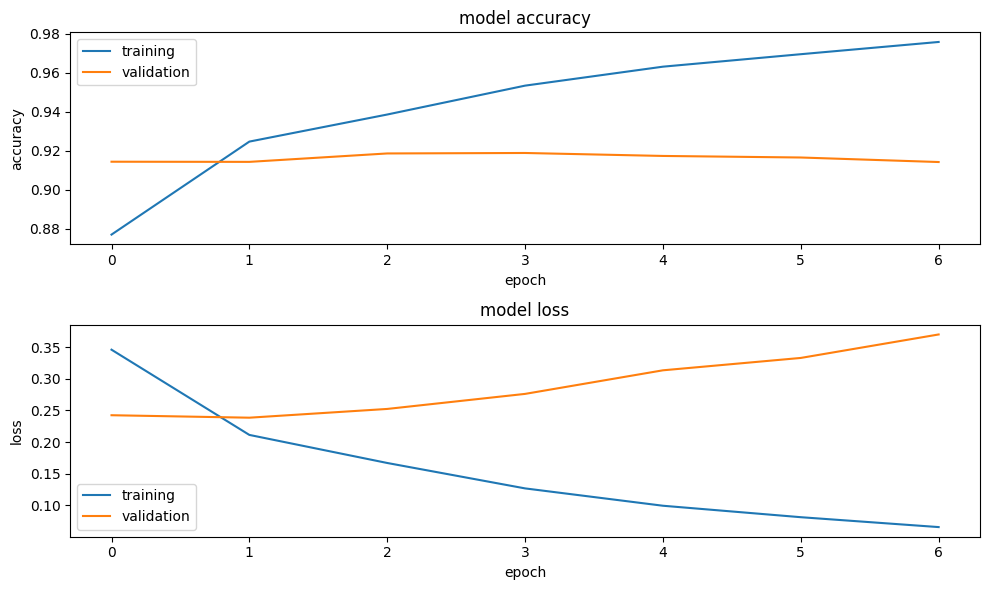

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      3210
           1       0.95      0.98      0.96      3180
           2       0.88      0.91      0.89      3000
           3       0.89      0.88      0.89      3116

    accuracy                           0.92     12506
   macro avg       0.92      0.92      0.91     12506
weighted avg       0.92      0.92      0.92     12506

Accuracy Score: 0.9153206460898768
Root Mean Square Error: 0.5326385473896539


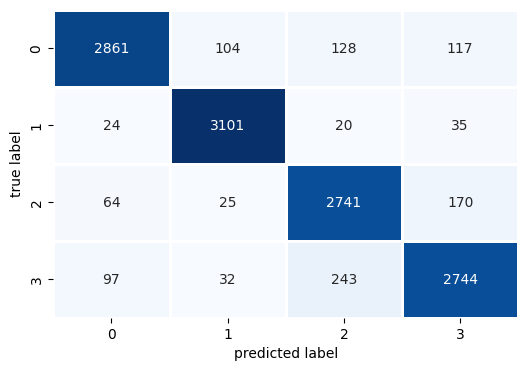

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1DCNN_dilation_kernelsize_loss_stop.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("1DCNN_dilation_kernelsize_loss_stop.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - accuracy: 0.8024 - loss: 0.5132 - val_accuracy: 0.9143 - val_loss: 0.2422
Epoch 2/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 69s 19ms/step - accuracy: 0.9223 - loss: 0.2222 - val_accuracy: 0.9159 - val_loss: 0.2388
Epoch 3/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9375 - loss: 0.1725 - val_accuracy: 0.9133 - val_loss: 0.2549
Epoch 4/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.9505 - loss: 0.1349 - val_accuracy: 0.9143 - val_loss: 0.2772
Epoch 5/200
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.9606 - loss: 0.1069 - val_accuracy: 0.9159 - val_loss: 0.3225
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9132 - loss: 0.2507
Test acc: 0.914
CPU times: user 3min 19s, sys: 28.3 s, total: 3min 47s
Wall time: 3min 38s


In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

Last Run: 2025-11-01 03:37:50
